# Using Images from HEASARC

In this notebook, we show how to search for and retrieve images from the HEASARC's holdings.

* [1. Finding](#finding) HEASARC SIA resources from the NAVO directory with TAP
* [2. Using](#sia) SIA to retrieve an image from SkyView


In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import requests, io, astropy
from IPython.display import Image, display

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
import astropy.io.fits as apfits

## For pretty displays
import aplpy

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

<a id="finding"></a>

# 1.  Finding HEASARC SIA resources from the NAVO directory with TAP

The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the __[Simple Image Access](http://www.ivoa.net/documents/SIA/)__ (SIA) protocol. But first, how do you know what sorts of images are available?

First, we can find out what SIA resources are available through SkyView. These are listed in a registry at STScI which we can access through the __[Table Access Protocol](http://www.ivoa.net/documents/TAP/)__ (TAP). The TAP protocol is described in detail in its own notebook.  Here, we submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources: 

In [2]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,b.res_description from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
##  If you want to see what requests gives you, you can look at the URL it actually constructed:
#print(r.url)
##  And the raw text of what it got back:
# print(r.text)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
table=Table.read(io.BytesIO(r.content))
table

short_name,res_description
object,object
1420MHz,This survey was taken with the Bonn Stockert 25m telescope. It was distributed on the NRAO &amp;lt;i&amp;gt;Images from the Radio Sky&amp;lt;/i&amp;gt; CD-ROM. This image was delivered as a four map mosaic but was combined into a single map before being included in &amp;lt;i&amp;gt;SkyView&amp;lt;/i&amp;gt;.
2MASS,"2MASS data were collected by uniformly scanning the entire sky in three near-infrared bands to detect and characterize point sources brighter than about 1 mJy in each band, with signal-to-noise ratio (SNR) greater than 10, using a pixel size of 2.0"". This achieves an 80,000-fold improvement in sensitivity relative to earlier surveys. 2MASS used two new, highly-automated 1.3-m telescopes, one at Mt. Hopkins, AZ, and one at CTIO, Chile. Each telescope is equipped with a three-channel camera, each channel consisting of a 256 by 256 array of HgCdTe detectors, capable of observing the sky simultaneously at J (1.25 microns), H (1.65 microns), and K&amp;lt;sub&amp;gt;s&amp;lt;/sub&amp;gt; (2.17 microns). &amp;lt;p&amp;gt;2MASS images and other data products can be obtained at the &amp;lt;a href=""http://irsa.ipac.caltech.edu/applications/2MASS/QL/""&amp;gt;NASA/IPAC Infrared Science Archive&amp;lt;/a&amp;gt;"
408MHz,"This survey is a mosaic of data taken at Jodrell Bank, Effelsberg and Parkes telescopes. The data was distributed in the NRAO &amp;lt;i&amp;gt;Images from the Radio Sky&amp;lt;/i&amp;gt; CD ROM."
AKARI,"The AKARI (formerly Astro-F) mission is a Japanese second generation all-sky infrared survey mission. SkyView currently includes surveys from the four bands of the FIS instrument: N60, WIDE-S, WIDE-L and N160. &amp;lt;p&amp;gt; These surveys cover 99% of the sky in four photometric bands centred at 65µm, 90µm, 140µm, and 160µm, with spatial resolutions ranging from 1-1.5'. &amp;lt;p&amp;gt; These data provide crucial information on the investigation and characterisation of the proper- ties of dusty material in the interstellar medium (ISM), since a significant portion of its energy is emitted between ~50 and 200 µm. The large-scale distribution of interstellar clouds, their thermal dust temperatures, and their column densities can be investigated with the improved spatial resolution compared to earlier all-sky survey observations. In addition to the point source distribution, the large-scale distribution of ISM cirrus emis- sion, and its filamentary structure, are well traced. &amp;lt;p&amp;gt; Data are obtained using using the &amp;lt;a href=http://jvo.nao.ac.jp/index-e.html&amp;gt;JVO &amp;lt;a&amp;gt;AKARI Simple Image Access Service."
ASCA,"The ASCAMASTER table contains data on all ASCA observations that were ever in any of the following states: 'Accepted', 'Scheduled Long-Term', 'Scheduled Short-Term', 'Processed', and 'Archived'. The final status of an observation is given by the parameter Status. Specific dates that affect the status of an observation are listed as the parameters scheduled_date, observed_date, processed_date, archived_date, and cycle. Notice that, if one or more of the date parameters are empty for a given observation, this means that that those particular processes have not occurred: e.g., if observed_date is empty, this means that the planned observation was not observed."
ASCA/AGN,"The Tartarus database contains the results of a detailed but systematic analysis of ASCA observations of active galactic nuclei (AGN). It contains source and background events files, spectra, ancillary response files and response matrices, images, and assorted light curves for a large number of ASCA AGN observations. Spectral fit results are done by automatic XSPEC fitting. This database table allows easy access to reduced AGN data for the whole community, allowing the maximum scientific return from the data. Availability of publishable light curves, images, and spectra (which can also be readily re-fitted) should be particularly valuable to astronomers with

<div class="alert alert-block alert-danger">
This should in future be implemented as a function, e.g.,<br>
    astroquery.heasarc.query_sia_services()<br>
But then we have to hide from the user the fact that results could come from either SkyView SIA or the Xamin SIA services (?).  
</div>

<a id="sia"></a>

# 2. Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for images of our favorite source.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

In [4]:
import astropy.coordinates as coord
coord=coord.SkyCoord.from_name("m51")
pos='{},{}'.format(coord.ra.deg,coord.dec.deg)

params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.1', "NAXIS":"300,300","interpolation":'LI'}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
swiftuvotvint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094496372&return=FITS,1
swiftuvotvint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotvint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094496372&nofits=1&quicklook=jpeg&return=jpeg,1
swiftuvotbint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094496644&return=FITS,2
swiftuvotbint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotbint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094496644&nofits=1&quicklook=jpeg&return=jpeg,2
swiftuvotuint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094497883&return=FITS,3
swiftuvotuint,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094497883&nofits=1&quicklook=jpeg&return=jpeg,3
swiftuvotuvw1int,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094498340&return=FITS,4
swiftuvotuvw1int,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuvw1int&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094498340&nofits=1&quicklook=jpeg&return=jpeg,4
swiftuvotuvw2int,202.48416700000001,47.230556,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuvw2int&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094498830&return=FITS,5


<div class="alert alert-block alert-danger">
This should be a function, e.g.,<br>
astroquery.heasarc.query_skyview()
</div>

Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [5]:
###  Inside the table is a numpy record array that you can access like this, for example:
#print(table.array[4][8])
#  Or like this
print(table[4]['URL'])
### To download the FITS image itself:
print(table[5]['URL'])

b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094497883&return=FITS'
b'https://skyview.gsfc.nasa.gov/cgi-bin/images?position=202.484167%2C47.230556&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1513094497883&nofits=1&quicklook=jpeg&return=jpeg'


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [6]:
##  Note that there are bugs with some of these datasets, 
##  since they are new in SkyView.  Selecting the U-band image.
##  (The decode is needed in Python 3.5 because it comes back a byte type.)
display(Image(url=table['URL'][5].decode("utf-8")))

In [7]:
## Download the FITS image?
import urllib.request
urllib.request.urlretrieve(table['URL'][4].decode("utf-8"), "image.fits")


('image.fits', <http.client.HTTPMessage at 0x10fcd24e0>)

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

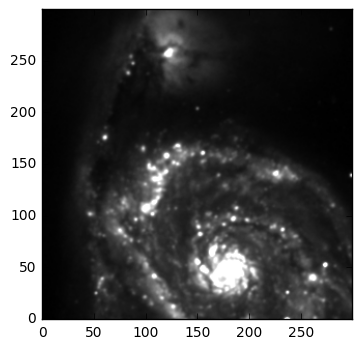

In [8]:
#hdu_list=apfits.open(table['URL'][4].decode("utf-8"))
hdu_list=apfits.open('image.fits')
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.2)

<div class="alert alert-block alert-danger">
Why does it so frequently time out when handing the URL to apfits.open()?
</div>

### Now with aplpy

INFO: Auto-setting vmin to  1.542e-02 [aplpy.core]


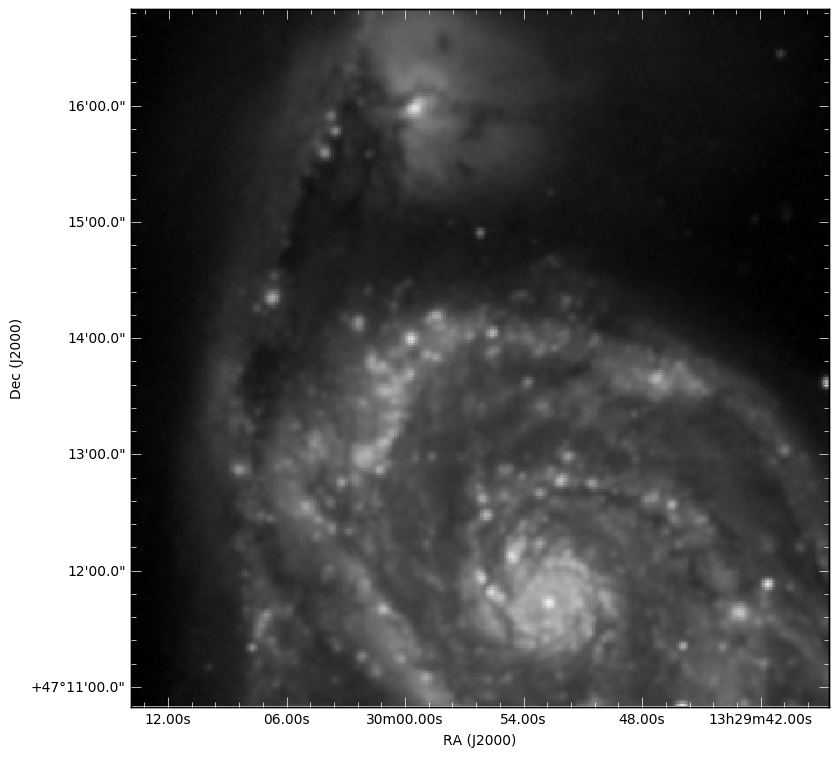

In [9]:
gc = aplpy.FITSFigure(hdu_list)
gc.show_grayscale(stretch='log', vmax=1.)

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [10]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
urllib.request.urlretrieve(table['URL'][0].decode("utf-8"), "image.fits")

('image.fits', <http.client.HTTPMessage at 0x1118fa908>)

INFO: Auto-setting vmin to  5.143e-03 [aplpy.core]


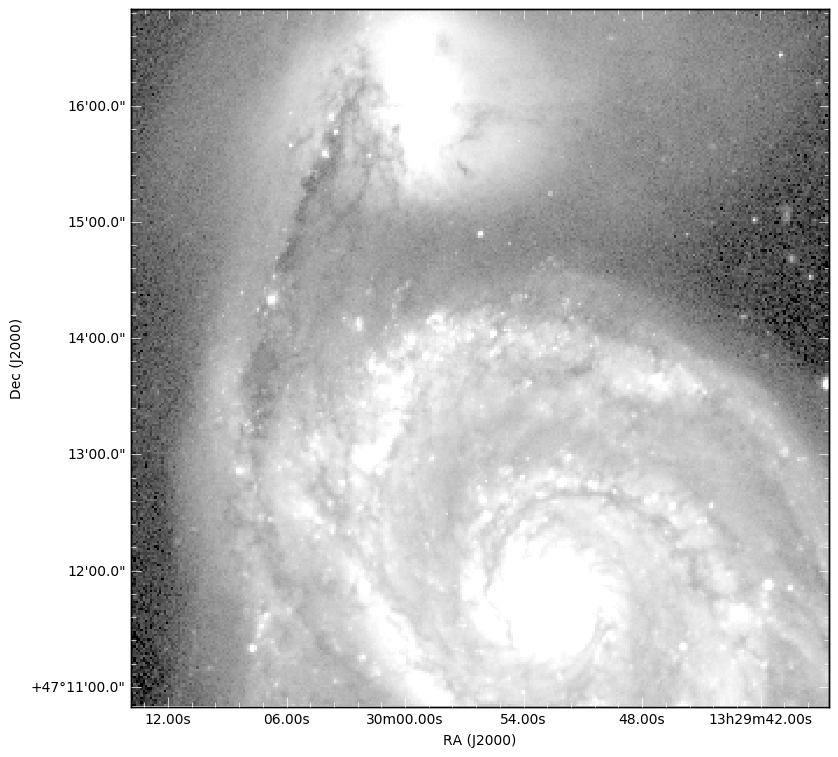

In [11]:
hdu_list=apfits.open('image.fits')
gc = aplpy.FITSFigure(hdu_list)
gc.show_grayscale(stretch='log', vmax=1.)


# 3. Retrieving a 'raw' image from Xamin
The SkyView service is a flexible and powerful way to view any sized region of the sky and to compare among different telescopes.  The results, however, are interpolated and mosaic'd in a way that makes the scientific interpretation more complicated.  If you wish to retrieve the original observation data, these are listed in HEASARC's __[Xamin](https://heasarc.gsfc.nasa.gov/xamin/)__ service, which also provides an SIA interface.

Above, we used the TAP to query the registry of SIA services and selected a Swift UVOT image from SkyView.  But we could also query Xamin for the original observation images.

<div class="alert alert-block alert-danger">
To be fixed:
</div>

In [17]:
params = {'survey': 'swiftuvot', 'POS': pos}
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/sia?table=swiftuvlog&', params=params)
table=Table.read(io.BytesIO(r.content))
table

ValueError: None:13157:10: ValueError: invalid literal for int() with base 10: 'null' (in row 57, col 'SIA_naxis')